# P36 - Gender image categorization

#### Author: Aitor Diaz de Otazu

In [1]:
import os
# supress tensorflow logging other than errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import neat
import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
import neat
from skimage import io
import pandas as pd
import requests
import cv2
import scipy.io

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Dropout, Flatten
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras import metrics







Using TensorFlow backend.


### Procesing the dataset

NOTE: The used dataset does not include in the project due to the limit size.

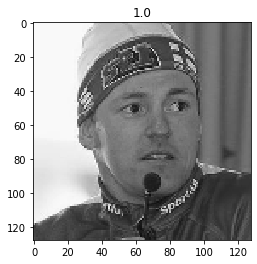

In [5]:
#Loading the structure
data = scipy.io.loadmat('wiki.mat')

paths_array = data.get('wiki')['full_path']

paths=[]
y_data = []


paths = paths_array[0][0][0]

#Loading all images
n_samples = paths.shape[0]
X_data = []
    
for i in range(n_samples):
    if i % 10 == 0:
        print ("Loading images: %2f" % (i/n_samples * 100) + "%", end="\r")
        
    #Read the image and resize to 128x128 gray scale image
    img = cv2.resize(io.imread("wiki_crop/"+paths[i][0], as_gray=True),(128,128),interpolation=cv2.INTER_CUBIC)
    
    #Skip any corrupted image
    if np.all(img==0) or np.any(np.isnan(data.get('wiki')['gender'][0][0][0][i])):
        continue
    else:
        X_data.append(img)
        y_data.append(data.get('wiki')['gender'][0][0][0][i])
X_data = np.array(X_data)
y_data = np.array(y_data)


plt.title(y_data[0])
plt.imshow(X_data[0], cmap=plt.cm.gray)
plt.show()



### Creating a balanced sample for fit the model

In [6]:
x_male=[]
x_female=[]
y_male=[]
y_female =[]

for x , y in zip(X_data, y_data):
    if y == 0:
        x_female.append(x)
        y_female.append(y)
    else:
        x_male.append(x)
        y_male.append(y)
        
x_male=np.array(x_male)
x_female=np.array(x_female)
y_male=np.array(y_male)
y_female =np.array(y_female)

x_train = np.concatenate((x_female[:10000],x_male[:10000]))
y_train = np.concatenate((y_female[:10000],y_male[:10000]))
x_test = np.concatenate((x_female[10000:],x_male[10000:12100]))
y_test = np.concatenate((y_female[10000:],y_male[10000:12100]))

indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)

x_train = x_train[indices]
y_train = y_train[indices]


x_train = x_train.reshape(-1,128*128)
x_test = x_test.reshape(-1,128*128)

print("Number of male: " + str(np.count_nonzero(y_train==1)))
print("Number of female: " + str(np.count_nonzero(y_train==0)))

Number of male: 10000
Number of female: 10000


### Implementing the MLP 

In [7]:

mpl_clf = MLPClassifier(hidden_layer_sizes=(32,32,64,128), random_state=1, 
                        batch_size=2000, max_iter=200,shuffle=True,activation='logistic')

mpl_clf.fit(x_train,y_train)


mpl_prediction = mpl_clf.predict(x_test)




### Results

0.6314285714285715


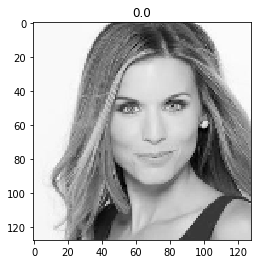

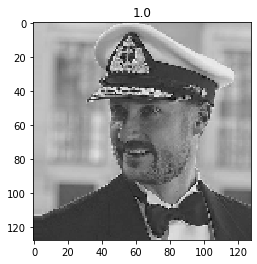

array([[1211,  889],
       [ 659, 1441]])

In [8]:
print(accuracy_score(y_test, mpl_prediction))

plt.title(mpl_prediction[28])
plt.imshow(x_test[28].reshape((128,128)), cmap=plt.cm.gray)
plt.show()
plt.title(mpl_prediction[4001])
plt.imshow(x_test[4001].reshape((128,128)), cmap=plt.cm.gray)
plt.show()
confusion_matrix(y_test, mpl_prediction)

### Implementing a CNN to compare the results

In [16]:
x_train = x_train.reshape(20000,128,128,1)

seq = Sequential()

seq.add(Conv2D(64, (3,3), activation='relu', input_shape=(128,128,1)))
seq.add(MaxPooling2D(pool_size=(2,2)))

seq.add(Conv2D(64, (3,3), activation='relu'))
seq.add(MaxPooling2D(pool_size=(2,2)))

seq.add(Conv2D(128, (3,3), activation='relu'))
seq.add(MaxPooling2D(pool_size=(2,2)))

seq.add(Flatten())
seq.add(Dense(128, activation='relu'))
seq.add(Dropout(0.25))
seq.add(Dense(1, activation='sigmoid'))

seq.compile(optimizer='rmsprop',
            loss='binary_crossentropy',
            metrics=['accuracy'])

checkpoint = ModelCheckpoint("checkpoints/seq_checkpiont.hdf5", monitor='loss', 
                             verbose=1,save_best_only=True, mode='auto', period=1)

history=seq.fit(x_train, y_train, epochs=30)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/30
20000/20000 [==============================] - 406s 20ms/step - loss: 0.7169 - accuracy: 0.6237
Epoch 2/30
20000/20000 [==============================] - 337s 17ms/step - loss: 0.5553 - accuracy: 0.7227
Epoch 3/30
20000/20000 [==============================] - 375s 19ms/step - loss: 0.4915 - accuracy: 0.7673
Epoch 4/30
20000/20000 [==============================] - 393s 20ms/step - loss: 0.4433 - accuracy: 0.7897
Epoch 5/30
20000/20000 [==============================] - 373s 19ms/step - loss: 0.4180 - accuracy: 0.8080
Epoch 6/30
20000/20000 [==============================] - 364s 18ms/step - loss: 0.4870 - accuracy: 0.8220
Epoch 7/30
20000/20000 [==============================] - 368s 18ms/step - loss: 0.4129 - accuracy: 0.8289
Epoch 8/30
20000/20000 [==============================] - 364s 18ms/step - loss: 0.4155 - accuracy: 0.8379
Epoch 9/30
20000/20000 [========================

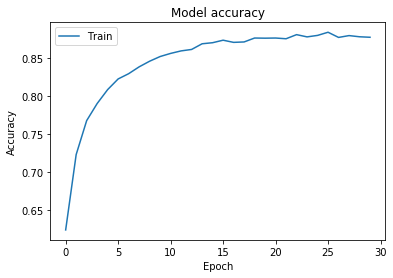

In [19]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
indices_2 = np.arange(x_test.shape[0])
np.random.shuffle(indices_2)

x_test = x_test[indices_2]
y_test = y_test[indices_2]

x_test = x_test.reshape(4200,128,128,1)
pred = seq.predict_classes(x_test)

print('Accuracy: ' + str(accuracy_score(y_test, pred)))

Accuracy: 0.7833333333333333


/Users/aitor/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


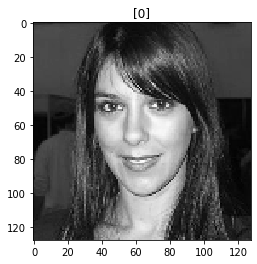

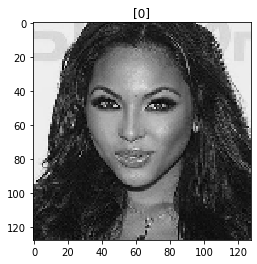

array([[1597,  503],
       [ 407, 1693]])

In [22]:
plt.title(pred[7])
plt.imshow(x_test[7].reshape(128,128), cmap=plt.cm.gray)
plt.show()
plt.title(pred[28])
plt.imshow(x_test[28].reshape(128,128), cmap=plt.cm.gray)
plt.show()
confusion_matrix(y_test, pred)